In [67]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [68]:
##little function to help us to read the downloaded csvs

def read_cvs(path_to_csvs):
##input: the folder with all the traget csvs
##output dictionary with all the csvs as dataframes with the filename as the key

    dict = {}
    for csv in os.listdir(path_to_csvs):
        dict[csv.split('.')[0]] = pd.read_csv(path_to_csvs + csv,dtype='unicode')
    return dict

In [69]:
##LOAD UP THE DATA
## 0. check the curernt path, configured to run from /python_source
print(os.getcwd())

## 1. define paths 
main_path = "../"
plot_path = main_path + '/plots/'
data_path = main_path + '/data/raw/core/'

##the specific subfolders check the ABCD data dictionary

general_path = data_path + '/abcd-general/'
gender_sexual_path = data_path + '/gender-identity-sexual-health/'
mental_health_path = data_path + '/mental-health/'
physical_health_path = data_path + '/physical-health/'

#med1_rxnorm_p


##2. check if the path exists
isExist = os.path.exists(plot_path)
isExist2 = os.path.exists(data_path)
print(f'plot paths correctly set: {isExist}, data path: {isExist2}')

##3. read up the csvs (usin the fuction created above)
gender_csvs = read_cvs(gender_sexual_path)
general_csvs = read_cvs(general_path)
mental_health_csvs = read_cvs(mental_health_path)
physical_health_csvs = read_cvs(physical_health_path)

##3. look at the keys from the filenames
print(f'Keys in dictionary gender/sexual identity {gender_csvs.keys()}')
print(f'Keys in dictionary general {general_csvs.keys()}')
print(f'Keys in dictionary mental health {mental_health_csvs.keys()}')
print(f'Keys in dictionary physical health {physical_health_csvs.keys()}')


#now we have the dictionary for all the csvs in abcd general !



/Users/samuelheczko/Documents/School/phd/mini-projects/Kelleher_block_2/code/python_source
plot paths correctly set: True, data path: True
Keys in dictionary gender/sexual identity dict_keys(['gish_p_gi', 'gish_y_sex', 'gish_p_sex', 'gish_y_gi'])
Keys in dictionary general dict_keys(['abcd_p_demo', 'abcd_y_lt', 'abcd_y_lf', 'abcd_p_ocp', 'abcd_p_screen'])
Keys in dictionary mental health dict_keys(['mh_y_cbb', 'mh_y_le', 'mh_p_ksads_ss', 'mh_t_bpm', 'mh_p_ksads_sep', 'mh_y_ksads_cd', 'mh_p_ksads_gad', 'mh_p_ksads_ocd', 'mh_p_ksads_hi', 'mh_y_bisbas', 'mh_y_ksads_bg', 'mh_p_ksads_odd', 'mh_p_ksads_ptsd', 'mh_p_cbcl', 'mh_p_eatq', 'mh_p_ksads_phb', 'mh_y_ksads_ed', 'mh_y_ksads_si', 'mh_p_pss', 'mh_p_ksads_asd', 'mh_y_ksads_gad', 'mh_p_ksads_psy', 'mh_y_7up', 'mh_p_abcl', 'mh_p_ksads_bg', 'mh_p_ksads_bp', 'mh_y_pps', 'mh_p_ksads_ago', 'mh_p_ksads_dmdd', 'mh_y_peq', 'mh_p_ksads_sad', 'mh_y_ksads_bip', 'mh_y_ksads_dmdd', 'mh_p_ders', 'mh_p_ksads_slp', 'mh_p_ksads_cd', 'mh_p_ssrs', 'mh_y_ksa

In [70]:
##ADD SEX AT BIRTH + GENDER CONFORMITY TO THE DATAFRAME

dataframe_for_regression = pd.DataFrame() ##create empty dataframe to save the sex at birth and the gender conformity


subjects_gender_i = gender_csvs['gish_y_gi']['src_subject_id'].unique() ##extract subject codes in gender/sexuality dataset
subjects_demo = general_csvs['abcd_p_demo']['src_subject_id'].unique() ##extract subject codes in general geo dataset
subjects = np.array(list(set(subjects_demo) & set(subjects_gender_i))) ##define subjects that are present in both

gender_list = [] ##initieate arrays - for strings we need lists rather than np arrays
gender_i_list = np.zeros(len(subjects))
gender_number = np.zeros(len(subjects))

for subject_i, subject in enumerate(subjects):
    #print(subject)
    boolean_subject_gi = np.isin(gender_csvs['gish_y_gi']['src_subject_id'],[subject])
    boolean_subject_demo = np.isin(general_csvs['abcd_p_demo']['src_subject_id'],[subject])
    
    if general_csvs['abcd_p_demo'].iloc[boolean_subject_demo,:]['demo_sex_v2'].dropna().astype(float).values == 1.0:
        gender_list.append('M') ##save the gender
        gender_number[subject_i] = 0 ##0.0 for males
        
        gender_i_list[subject_i] = gender_csvs['gish_y_gi'].iloc[boolean_subject_gi,:]['gish_m1_y'].dropna().astype(float).mean() ##save the average feeling of belonign to male gender (higher - more conforming)
    else:
        gender_list.append('F')
        gender_number[subject_i] = 1 ##1.0 for females
        gender_i_list[subject_i] = gender_csvs['gish_y_gi'].iloc[boolean_subject_gi,:]['gish_f1_y'].dropna().astype(float).mean()  ##save the average feeling of belonign to female gender (higher - more conforming)

dataframe_for_regression['Subject'] = subjects
dataframe_for_regression['Sex_at_birth'] = gender_list
dataframe_for_regression['Sex_numerical'] = gender_number
dataframe_for_regression['Gender_Conformity'] = gender_i_list







    

<Axes: >

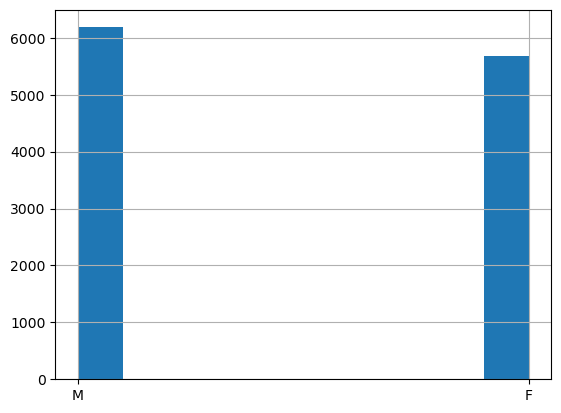

In [71]:
dataframe_for_regression.Sex_at_birth.hist()

In [72]:
##ADD ADHD SYMPTOMS

##Initiate the arrays we need - in addition to what we had first we need to add a structure to account for all the events. And in additon we need to account that some time points are missing!

events = mental_health_csvs['mh_p_cbcl']['eventname'].unique() ##find all the events that are in the data
event_dict = {} ##intiate the dictionary
for possible_event in events:
    event_dict[possible_event] = [] ##all entries in the dictionary are lists - we will add elements later
event_dict['average_over_years'] = [] ##average row

#event_dict['Subject1'] = [] code for testing that we actually match the subject 


for subject_i, subject in enumerate(subjects): #for all subjects as found earlier

    score = mental_health_csvs['mh_p_cbcl'][mental_health_csvs['mh_p_cbcl']["src_subject_id"].isin([subject])][['eventname','cbcl_scr_dsm5_adhd_t']] ##find the subjects in the mental health dataframe (all events)
    event_dict['average_over_years'].append(score['cbcl_scr_dsm5_adhd_t'].astype(float).mean()) ##take average score

    #event_dict['Subject1'].append(subject) code for testing that we actually match the subject 

    for t in events: ##for all events
        event_subject_score = score[score['eventname'] == t]['cbcl_scr_dsm5_adhd_t'].values ##find the score of event and subject combo
        
        if len(event_subject_score) == 0: ##account for the fact that some events are missing
            event_subject_score = np.NaN ##if missing set score to nan
        else: 
            event_subject_score = event_subject_score[0]  ##if not missing use the score
        event_dict[t].append(event_subject_score)
    


## add the dictionary we created to the dataframe we made earlier (make a copy thats easier to change the code leading to it) add the ADHD perfix to keys we have
dataframe_for_regression_2 = pd.concat([dataframe_for_regression,pd.DataFrame(event_dict).add_prefix('ADHD_')],axis = 1)


In [127]:
## ADD THE STIMULANT MEDICATION

#1. List all the meds that are presnet in the sample
list_meds = []
for i in physical_health_csvs['ph_p_meds']['med1_rxnorm_p'].unique(): #loop here to print them on each row separately
    #print(i) ##
    list_meds.append(i) #add to the list


#2. find the kids with stimulant medications - the problem: many medications have pill, oral product, different pill strenght listed as spearate + they have id numbers which are annoyig ot type - we want to find a list of all of them in the dataset

##define the terms we are looking for wihting the list of drugs the children are on
search_terms = ['Methylphenidate','Ritalin','Quillivant','QuilliChew','Methylin','Metadate','Jornay','Daytrana','Cotempla','Concerta','Aptensio','Adhansia' ##Methylphenidate and its brand names from RxNav
                'Dextroamphetamine','Adderall','Dexedrine','ProCentra', ##Dextroamphetamine and its brand names - we dont include Mydayis, ProCentra, Xelstrym or Zenzedi as they are not presnet in our dataset
                'lisdexamfetamine','Vyvanse', ##lisdexamfetamine and it's brand name
                'Amphetamine','Adzenys','Dyanavel','Evekeo',] ##amphetamine and its brand names

stim_list = [] 
for search_term in search_terms: ##loop over the search terms defined above
    for med in list_meds[1:]: #loop over all the meds - first is nan 
        if search_term in med:  #if a match (annywhere within the string)
            stim_list.append(med) ##add the full medication name to our list of 
stim_list = list(dict.fromkeys(stim_list))    ##delete duplicates

mask = physical_health_csvs['ph_p_meds'][['med1_rxnorm_p','med2_rxnorm_p','med3_rxnorm_p','med4_rxnorm_p','med5_rxnorm_p','med5_rxnorm_p','med7_rxnorm_p','med8_rxnorm_p','med9_rxnorm_p','med10_rxnorm_p','med11_rxnorm_p']].isin(stim_list).sum() >= 1
rows_with_meds = mask[mask].index.tolist()


physical_health_csvs['ph_p_meds'][physical_health_csvs['ph_p_meds'][rows_with_meds].isin(stim_list).sum(axis = 1) > 0].head() ##check our thing works: the data frame where only the kids with stimulants are presnet


stimulant_subject_list = physical_health_csvs['ph_p_meds'][physical_health_csvs['ph_p_meds'][rows_with_meds].isin(stim_list).sum(axis = 1) > 0]['src_subject_id']## we have a list of subjects that have taken some sort of stimulant medicaton over the study time
stimulant_subject_list = list(set(stimulant_subject_list)) ##delete duplicates


stim_dict = {} ##intiate the dictionary for stims
stim_dict['subject_med'] = stimulant_subject_list ##add the subject number first so it's on the left
#infos = ['dose','pres']
infos = ['pres']
for info in infos:
    for possible_event in events:
        stim_dict[info + '_' + possible_event] = [] ##all entries in the dictionary are lists - we will add elements later
#stim_dict['average_dose_over_years'] = [] ##average row
stim_dict['subject_med'] = stimulant_subject_list

for subject_i, subject in enumerate(stimulant_subject_list): #for all subjects as found earlier

    pres_dose_all = physical_health_csvs['ph_p_meds'][physical_health_csvs['ph_p_meds']["src_subject_id"].isin([subject])][['eventname','medication1_dosage']+ rows_with_meds] ##find the subjects in the mental health dataframe (all events)
    #event_dict['Subject1'].append(subject) code for testing that we actually match the subject 
    #stim_dict['average_dose_over_years'].append(pres_dose_all['medication1_dosage'].dropna().astype(float).mean())
    for t in events: ##for all events
        #print(pres_dose_all[pres_dose_all][pres_dose_all[pres_dose_all].notnull()])
        notnull_values = pres_dose_all[pres_dose_all['eventname'] == t][rows_with_meds].stack().dropna().tolist()
        notnull_values = list(set(stim_list) & set(notnull_values))
        #print(notnull_values)
        if len(notnull_values) == 0:
            event_subject_pres = np.NaN
        else:
            #event_subject_dose = event_subject_dose[0]
            event_subject_pres = notnull_values
        #stim_dict['dose_' + t].append(event_subject_dose)
        stim_dict['pres_' + t].append(event_subject_pres)


stim_dict = pd.DataFrame(stim_dict).add_prefix('meds_')


##add binary tag for any use
dataframe_for_regression_2['meds_Stimulant'] = 0.

stimulant_mask_2 = dataframe_for_regression_2['Subject'].isin(stimulant_subject_list)

dataframe_for_regression_2.loc[stimulant_mask_2,'meds_Stimulant'] = 1.0 

dataframe_for_regression_3 = dataframe_for_regression_2.merge( ##make new datframe with the medicaiton data added for each timepoint of the study
    stim_dict,
    how='left',
    left_on='Subject',
    right_on='meds_subject_med'
)


In [160]:
physical_health_csvs['ph_p_meds'][physical_health_csvs['ph_p_meds']['eventname'] == '_year_follow_up_y_arm_1']['med1_rxnorm_p'].isnull().sum()


4746

In [75]:
stimulant_subject_list = physical_health_csvs['ph_p_meds'][physical_health_csvs['ph_p_meds'][rows_with_meds].isin(stim_list).sum(axis = 1) > 0]['src_subject_id']## we have a list of subjects that have taken some sort of stimulant medicaton over the study time
stimulant_subject_list = list(set(stimulant_subject_list)) ##delete duplicates

stimulant_subject_list_1 = physical_health_csvs['ph_p_meds'][physical_health_csvs['ph_p_meds']['med1_rxnorm_p'].isin(stim_list)]['src_subject_id'] ## we have a list of subjects that have taken some sort of stimulant medicaton over the study time
stimulant_subject_list_1 = list(set(stimulant_subject_list_1)) ##delete duplicates

print(len(stimulant_subject_list),len(stimulant_subject_list_1))

1163 1073


In [76]:
physical_health_csvs['ph_p_meds'][physical_health_csvs['ph_p_meds'][rows_with_meds].isin(stim_list).sum(axis = 1) > 0][rows_with_meds]


(~physical_health_csvs['ph_p_meds']['med1_rxnorm_p'].isin(stim_list) & physical_health_csvs['ph_p_meds']['med5_rxnorm_p'].isin(stim_list)).sum()


8

In [77]:
physical_health_csvs['ph_p_meds'][['med1_rxnorm_p','eventname','src_subject_id']][physical_health_csvs['ph_p_meds']['eventname'].isin(['3_year_follow_up_y_arm_1'])].dropna()

physical_health_csvs['ph_p_meds'][['med1_rxnorm_p','med2_rxnorm_p','eventname','src_subject_id']][physical_health_csvs['ph_p_meds']['src_subject_id'] == 'NDAR_INV6ETG8KHZ']


mask = physical_health_csvs['ph_p_meds'][['med1_rxnorm_p','med2_rxnorm_p','med3_rxnorm_p','med4_rxnorm_p','med5_rxnorm_p','med5_rxnorm_p','med7_rxnorm_p','med8_rxnorm_p','med9_rxnorm_p','med10_rxnorm_p','med11_rxnorm_p']].isin(stim_list).sum() >= 1


/Users/samuelheczko/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


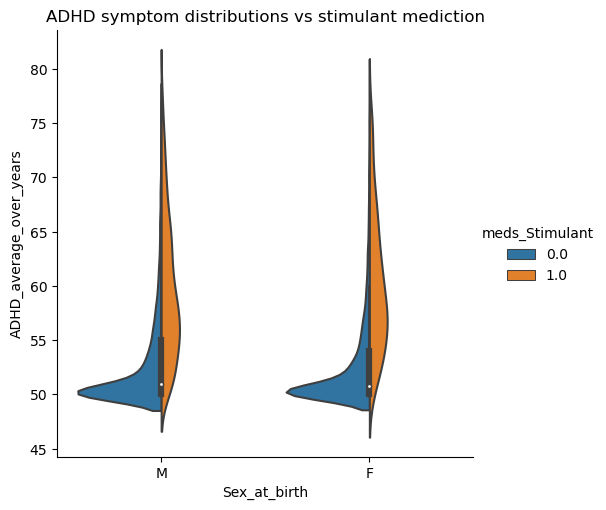

In [78]:
##our first result ! sanity check that our data minig tool is working corretly


sns.catplot(data = dataframe_for_regression_3,x="Sex_at_birth", y = 'ADHD_average_over_years', hue = 'meds_Stimulant',
            kind="violin",
            split = True)
plt.title('ADHD symptom distributions vs stimulant mediction')

plt.savefig(plot_path + 'ADHD_distributions.png',bbox_inches='tight')





<Axes: >

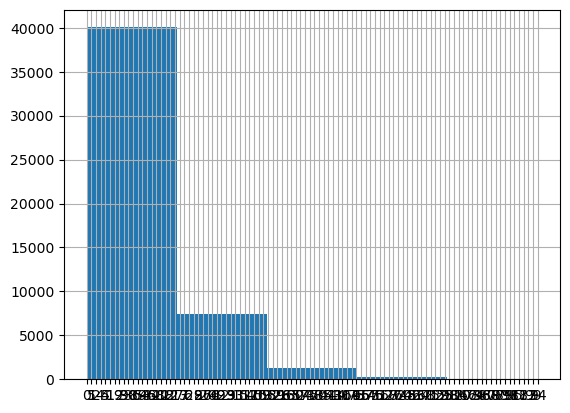

In [79]:
##add the psychotic experiences

mental_health_csvs['mh_y_pps']['pps_y_ss_severity_score'].hist(bins = 5)




In [129]:
###ADD PE

def extractor(csv_file,target_columns,average = True,subject_column_name = 'src_subject_id'):
    ##input: the csv where the data is, name of the column we want in the dictionary, setting if we want the average or not, data info like the name of the column where the subjects are (set for ABCD dataset 5.1)
    target_column_copy = target_columns

    target_columns = ['eventname', target_columns]
    print(target_column_copy)
    dict_ = {}
    events = csv_file['eventname'].unique()
    
    for possible_event in events:
        dict_[possible_event] = []
    if average: 
        dict_['average'] = []
    

    subject_list = csv_file[subject_column_name].unique()
    dict_['_subject'] = subject_list

    for subject_i, subject in enumerate(subject_list):  #loop for all subjects 
        score = csv_file[csv_file[subject_column_name].isin([subject])][target_columns]
        if average:
            
            dict_['average'].append(score[target_column_copy].dropna().astype(float).mean())
        for t in events:
            event_subject_variable = score[score['eventname'] == t][target_column_copy].values
            if len(event_subject_variable) == 0:
                event_subject_variable = np.NaN
            else:
                event_subject_variable = event_subject_variable[0]
            dict_[t].append(event_subject_variable)
    
    return dict_


dict_PE = extractor(csv_file= mental_health_csvs['mh_y_pps'],target_columns= 'pps_y_ss_severity_score')

df_PE = pd.DataFrame(dict_PE).add_prefix('PE_')

dataframe_for_regression_4 = dataframe_for_regression_3.merge( ##make new datframe with the medicaiton data added for each timepoint of the study
    df_PE,
    how='left',
    left_on='Subject',
    right_on='PE__subject'
)



pps_y_ss_severity_score


In [81]:
'''
df_PE = pd.DataFrame(dict_PE).add_prefix('PE_')

dataframe_for_regression_4 = dataframe_for_regression_3.merge( ##make new datframe with the medicaiton data added for each timepoint of the study
    df_PE,
    how='left',
    left_on='Subject',
    right_on='PE__subject'
)'''


dataframe_for_regression_4.keys()

Index(['Subject', 'Sex_at_birth', 'Sex_numerical', 'Gender_Conformity',
       'ADHD_baseline_year_1_arm_1', 'ADHD_1_year_follow_up_y_arm_1',
       'ADHD_2_year_follow_up_y_arm_1', 'ADHD_3_year_follow_up_y_arm_1',
       'ADHD_4_year_follow_up_y_arm_1', 'ADHD_average_over_years',
       'meds_Stimulant', 'meds_subject_med', 'meds_pres_baseline_year_1_arm_1',
       'meds_pres_1_year_follow_up_y_arm_1',
       'meds_pres_2_year_follow_up_y_arm_1',
       'meds_pres_3_year_follow_up_y_arm_1',
       'meds_pres_4_year_follow_up_y_arm_1', 'PE_baseline_year_1_arm_1',
       'PE_1_year_follow_up_y_arm_1', 'PE_2_year_follow_up_y_arm_1',
       'PE_3_year_follow_up_y_arm_1', 'PE_4_year_follow_up_y_arm_1',
       'PE_average', 'PE__subject'],
      dtype='object')

/Users/samuelheczko/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


LinearRegression()

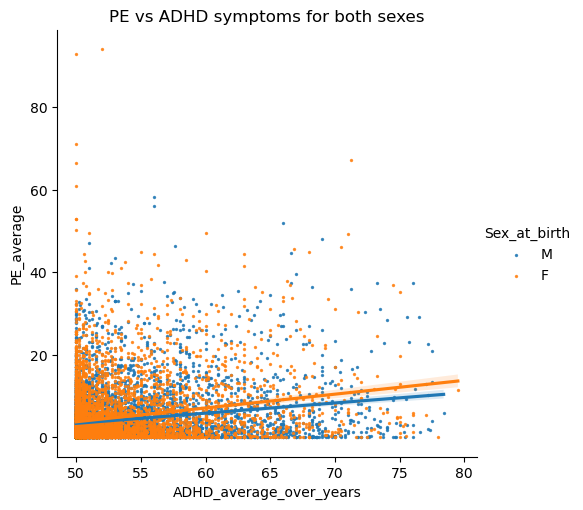

In [130]:

sns.lmplot(data=dataframe_for_regression_4, y="PE_average", x = "ADHD_average_over_years",hue = 'Sex_at_birth',scatter_kws={"s": 2})
plt.title('PE vs ADHD symptoms for both sexes')
dataframe_for_regression_5 = dataframe_for_regression_4.copy()


dataframe_for_regression_5['PE_average'].fillna(dataframe_for_regression_5['PE_average'].mean(), inplace=True)
dataframe_for_regression_5['ADHD_average_over_years'].fillna(dataframe_for_regression_5['ADHD_average_over_years'].mean(), inplace=True)

y = dataframe_for_regression_5['PE_average'].values.reshape(-1, 1)
x = dataframe_for_regression_5['ADHD_average_over_years'].values.reshape(-1, 1)

model = LinearRegression()
model.fit(x, y)

/Users/samuelheczko/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


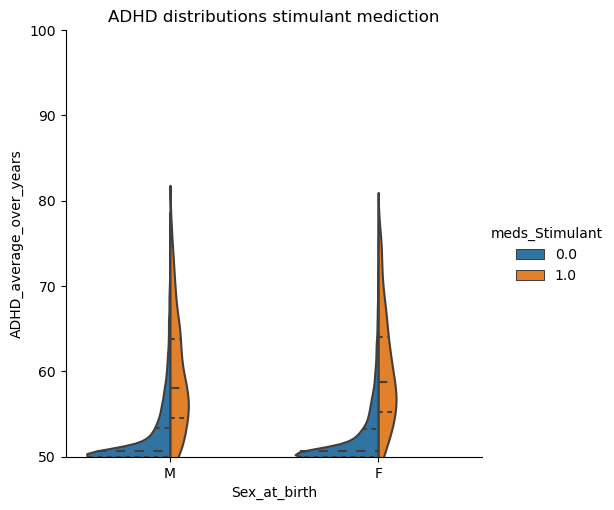

In [83]:
means_PE = dataframe_for_regression_5.groupby(['Sex_at_birth','meds_Stimulant'])['PE_average'].median()



sns.catplot(data = dataframe_for_regression_5,x="Sex_at_birth", y = 'ADHD_average_over_years', hue = 'meds_Stimulant',
            kind="violin",
            split = True,
            inner = 'quart',
            fill = 'None')
plt.title('ADHD distributions stimulant mediction')
plt.ylim([50,100])
#plt.scatter(x = np.array([0,0,1,1]), y = means_PE,color = 'r')
plt.savefig(plot_path + 'ADHD_distributions_sex_stimulants.png',bbox_inches='tight')





In [84]:
len(stim_list)

117

/Users/samuelheczko/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'PE vs ADHD symptoms for both sexes')

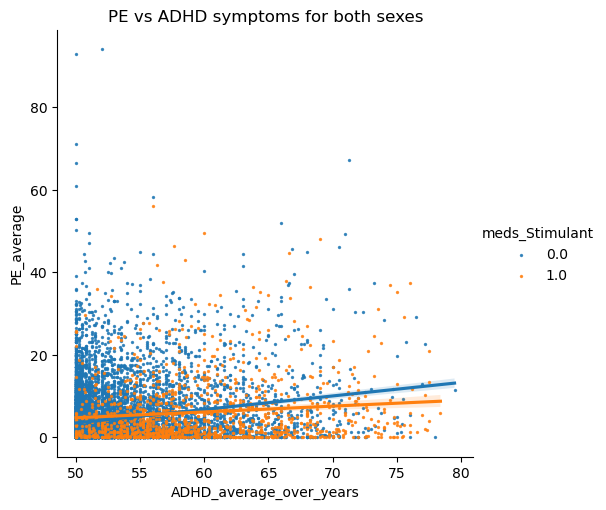

In [85]:
reg = dataframe_for_regression_5[['ADHD_average_over_years','PE_average','meds_Stimulant']].copy()
reg = reg.dropna()





sns.lmplot(data=reg, y="PE_average", x = "ADHD_average_over_years",hue = 'meds_Stimulant',scatter_kws={"s": 2})
plt.title('PE vs ADHD symptoms for both sexes')



In [86]:
print(pd.read_csv(data_path + '/linked-external-data/led_l_adi.csv')['reshist_addr2_adi_wsum'].isna().sum())
print(pd.read_csv(data_path + '/linked-external-data/led_l_adi.csv')['reshist_addr1_adi_wsum'].isna().sum())
print(pd.read_csv(data_path + '/linked-external-data/led_l_adi.csv')['reshist_addr3_adi_wsum'].isna().sum())
print(pd.read_csv(data_path + '/linked-external-data/led_l_adi.csv')['reshist_addr1_adi_wsum'].shape)


#abcd_p_demo

9988
226
11012
(11215,)


In [131]:
##ADD SOCIOECOONOMIC BACKGROUND 

##ADI
csv_adi = pd.read_csv(data_path + '/linked-external-data/led_l_adi.csv')
adi_sum_list = ['reshist_addr1_adi_wsum','reshist_addr2_adi_wsum','reshist_addr3_adi_wsum']
adi_dicts = []

for index, adi_column in enumerate(adi_sum_list):
    target_column = adi_column
    adi_1 = extractor(csv_adi,target_columns = target_column,average = False) #get the dictionary of the subjects and values from the csv
    adi_df = pd.DataFrame(adi_1)

    adi_df.rename(columns={"baseline_year_1_arm_1": f"{index}_baseline_year_1_arm_1", "_subject": f"_subject"},inplace = True)

    adi_dicts.append(adi_df)

adis = pd.concat(adi_dicts,axis=1)
print(adis['0_baseline_year_1_arm_1'].isna().sum())
adis = adis.loc[:,~adis.columns.duplicated()].copy()

adis['0_baseline_year_1_arm_1'] = adis['0_baseline_year_1_arm_1'].fillna(adis['1_baseline_year_1_arm_1'])
adis['0_baseline_year_1_arm_1'] = adis['0_baseline_year_1_arm_1'].fillna(adis['2_baseline_year_1_arm_1'])
adis = adis[['0_baseline_year_1_arm_1','_subject']] ##remove useless columns
adis = adis.add_prefix('ADI_')




reshist_addr1_adi_wsum
reshist_addr2_adi_wsum
reshist_addr3_adi_wsum
226


In [132]:
##careteakes (parent + parner) edu

##we start by replacing some values in the dataframes which are not useful for us

columns_to_replace = ['demo_prnt_ed_v2_2yr_l', 'demo_prtnr_ed_v2_2yr_l', 'demo_comb_income_v2', 'demo_comb_income_v2_l'] ##there are two column for the family income for some reason

# Loop through each column and replace 777 and 999 with NaN
for col in columns_to_replace:
    general_csvs['abcd_p_demo'][col] = general_csvs['abcd_p_demo'][col].astype(float).replace({777.0: np.nan, 999.0: np.nan})  #the 777 and 999 correspond to 'refuse to answer' and 'don't know' -replace them with nans


general_csvs['abcd_p_demo']['demo_prnt_ed_v2_2yr_l'] = general_csvs['abcd_p_demo']['demo_prnt_ed_v2_2yr_l'].astype(float).replace({23.0 : 15, 22.0 : 15}) ##23 and 22 correspond to not finisihng the college - replace them with value between high school/GED diploma and bachelors degree
general_csvs['abcd_p_demo']['demo_prtnr_ed_v2_2yr_l'] = general_csvs['abcd_p_demo']['demo_prtnr_ed_v2_2yr_l'].astype(float).replace({23.0 : 15, 22.0 : 15}) 


prnt_edu = extractor(general_csvs['abcd_p_demo'],target_columns='demo_prnt_ed_v2_2yr_l',average=True) ##use our extractor
partner_edu =  extractor(general_csvs['abcd_p_demo'],target_columns='demo_prtnr_ed_v2_2yr_l',average=True)

prnt_edu = pd.DataFrame(prnt_edu).add_prefix('PARENT_EDU_')
partner_edu = pd.DataFrame(partner_edu).add_prefix('PARTNER_EDU_')

demo_prnt_ed_v2_2yr_l
demo_prtnr_ed_v2_2yr_l


In [89]:
socio_economic_df

,CI_baseline_year_1_arm_1,CI_1_year_follow_up_y_arm_1,CI_2_year_follow_up_y_arm_1,CI_3_year_follow_up_y_arm_1,CI_4_year_follow_up_y_arm_1,CI_average,CI__subject,PARENT_EDU_baseline_year_1_arm_1,PARENT_EDU_1_year_follow_up_y_arm_1,PARENT_EDU_2_year_follow_up_y_arm_1,...,PARENT_EDU_4_year_follow_up_y_arm_1,PARENT_EDU_average,PARTNER_EDU_baseline_year_1_arm_1,PARTNER_EDU_1_year_follow_up_y_arm_1,PARTNER_EDU_2_year_follow_up_y_arm_1,PARTNER_EDU_3_year_follow_up_y_arm_1,PARTNER_EDU_4_year_follow_up_y_arm_1,PARTNER_EDU_average,ADI_0_baseline_year_1_arm_1,EDU_HIGER_AVERAGE
0,8.0,8.0,8.0,9.0,NaN,8.25,NDAR_INV003RTV85,NaN,NaN,13.0,...,NaN,13.000000,NaN,NaN,13.0,13.0,NaN,13.0,NaN,13.000000
1,NaN,5.0,NaN,3.0,NaN,4.00,NDAR_INV005V6D2C,NaN,NaN,6.0,...,NaN,6.000000,NaN,NaN,6.0,6.0,NaN,6.0,97.757630,6.000000
2,10.0,NaN,NaN,10.0,10.0,10.00,NDAR_INV007W6H7B,NaN,NaN,NaN,...,18.0,18.500000,NaN,NaN,NaN,18.0,19.0,18.5,27.144264,18.500000
3,10.0,10.0,10.0,NaN,NaN,10.00,NDAR_INV00BD7VDC,NaN,NaN,20.0,...,NaN,20.000000,NaN,NaN,20.0,NaN,NaN,20.0,104.137800,20.000000
4,6.0,6.0,7.0,8.0,8.0,7.00,NDAR_INV00CY2MDM,NaN,NaN,15.0,...,15.0,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,110.804726,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11863,9.0,9.0,10.0,9.0,10.0,9.40,NDAR_INVZZNX6W2P,NaN,NaN,18.0,...,18.0,18.000000,NaN,NaN,18.0,18.0,18.0,18.0,101.714140,18.000000
11864,10.0,10.0,9.0,10.0,10.0,9.80,NDAR_INVZZPKBDAC,NaN,NaN,19.0,...,19.0,19.000000,NaN,NaN,18.0,18.0,18.0,18.0,76.693430,19.000000
11865,10.0,10.0,9.0,10.0,9.0,9.60,NDAR_INVZZZ2ALR6,NaN,NaN,21.0,...,21.0,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,14.279168,21.000000
11866,3.0,NaN,NaN,NaN,9.0,6.00,NDAR_INVZZZNB0XC,NaN,NaN,NaN,...,19.0,19.000000,NaN,NaN,NaN,NaN,13.0,13.0,112.039980,19.000000


In [90]:
##income
general_csvs['abcd_p_demo']['demo_comb_income_v2'].fillna(general_csvs['abcd_p_demo']['demo_comb_income_v2_l'], inplace=True) ##two columns for income - merge them



comb_income = extractor(general_csvs['abcd_p_demo'],target_columns='demo_comb_income_v2',average=True) ##use our extractor
comb_income = pd.DataFrame(comb_income).add_prefix('CI_')


demo_comb_income_v2


In [91]:
#combine the SE variables
socio_economic_df = comb_income.copy()

socio_economic_df = socio_economic_df.merge( #combine the CI and PARTNER edu
    prnt_edu,
    how='left',
    left_on='CI__subject',
    right_on='PARENT_EDU__subject'
)

socio_economic_df = socio_economic_df.merge( #combine the CI and PARTNER edu
    partner_edu,
    how='left',
    left_on='CI__subject',
    right_on='PARTNER_EDU__subject'
)

socio_economic_df = socio_economic_df.merge( #combine the CI and PARTNER edu
    adis,
    how='left',
    left_on='CI__subject',
    right_on='ADI__subject'
)

socio_economic_df['EDU_HIGER_AVERAGE'] = socio_economic_df[['PARENT_EDU_average', 'PARTNER_EDU_average']].max(axis=1)

# Remove 'useless' subject colums 

columns_to_remove = ['PARENT_EDU__subject', 'PARTNER_EDU__subject', 'ADI__subject']  # list the removals

socio_economic_df.drop(columns=columns_to_remove, inplace=True) # remove



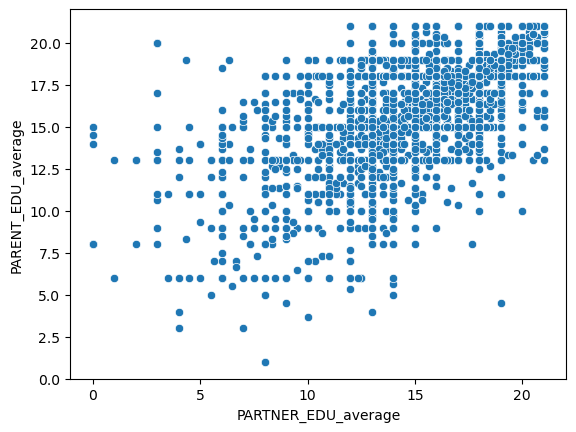

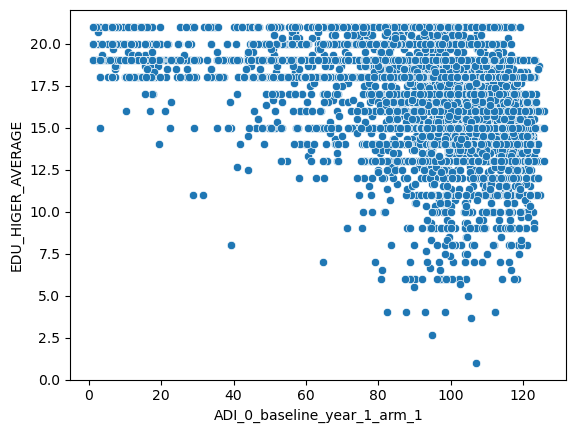

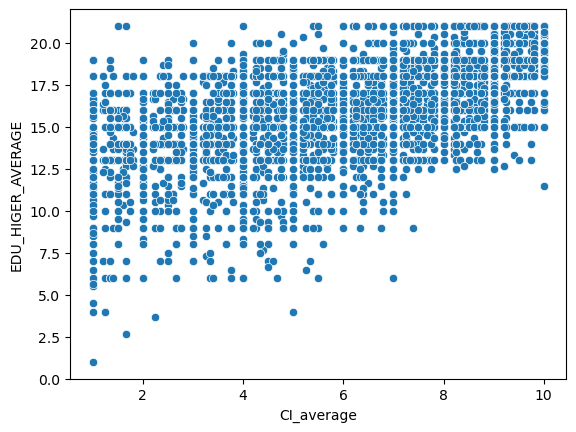

In [92]:
sns.scatterplot(data = socio_economic_df,x = 'PARTNER_EDU_average', y = 'PARENT_EDU_average' )
plt.show()
sns.scatterplot(data = socio_economic_df,x = 'ADI_0_baseline_year_1_arm_1', y = 'EDU_HIGER_AVERAGE')
plt.show()
sns.scatterplot(data = socio_economic_df,x = 'CI_average', y = 'EDU_HIGER_AVERAGE')
plt.show()

In [93]:
latent_factors = ['latent_factor_ss_general_ses','latent_factor_ss_social','latent_factor_ss_perinatal']
latent_factor_dfs = []
for index, latent_factor in enumerate(latent_factors):
    latent_factor_dict = extractor(general_csvs['abcd_y_lf'],target_columns=latent_factor,average=True)
    latent_factor_df = pd.DataFrame(latent_factor_dict).add_prefix(latent_factor + '_')
    latent_factor_dfs.append(latent_factor_df) ##use our extractor to add the latent factors
    if index != 0:
        print(index)
        latent_factor_dfs[0].merge(
        latent_factor_dfs[index],
        how='left',
        left_on=latent_factors[0] + '__subject',
        right_on=latent_factor + '__subject'
        )




        

latent_factor_ss_general_ses
latent_factor_ss_social
1
latent_factor_ss_perinatal
2


In [94]:
##ADD URBAN/RURAL INFO 

##URBAN/RURAL
csv_UR = pd.read_csv(data_path + '/linked-external-data/led_l_urban.csv')
UR_sum_list = ['reshist_addr1_urban_area','reshist_addr2_urban_area','reshist_addr3_urban_area'] ##the columns with urbanity binary info
UR_dicts = []

for index, UR_column in enumerate(UR_sum_list): ##loop over columns
    target_column = UR_column
    UR_1 = extractor(csv_UR,target_columns = target_column,average = False) #get the dictionary of the subjects and values from the csv
    UR_df = pd.DataFrame(UR_1)

    UR_df.rename(columns={"baseline_year_1_arm_1": f"{index}_baseline_year_1_arm_1", "_subject": f"_subject"},inplace = True) 

    UR_dicts.append(UR_df)

URs = pd.concat(UR_dicts,axis=1)
print(URs['0_baseline_year_1_arm_1'].isna().sum())
URs = URs.loc[:,~URs.columns.duplicated()].copy()

URs['0_baseline_year_1_arm_1'] = URs['0_baseline_year_1_arm_1'].fillna(URs['1_baseline_year_1_arm_1'])
URs['0_baseline_year_1_arm_1'] = URs['0_baseline_year_1_arm_1'].fillna(URs['2_baseline_year_1_arm_1'])
URs = URs[['0_baseline_year_1_arm_1','_subject']] ##remove useless columns
URs = URs.add_prefix('UR_')

reshist_addr1_urban_area
reshist_addr2_urban_area
reshist_addr3_urban_area
0


In [133]:
socio_economic_df = socio_economic_df.merge( #combine the CI and PARTNER edu
    URs,
    how='left',
    left_on='CI__subject',
    right_on='UR__subject'
)
socio_economic_df.drop(columns = ['UR__subject'],inplace=True)

In [134]:
dataframe_for_regression_6 = dataframe_for_regression_5.merge( ##merge into the dataframe for regression
    socio_economic_df,
    how = 'left',
    left_on = 'Subject',
    right_on = 'CI__subject'
)
dataframe_for_regression_6.drop(columns= ['CI__subject'],inplace=True) 

In [97]:
dataframe_for_regression_6

,Subject,Sex_at_birth,Sex_numerical,Gender_Conformity,ADHD_baseline_year_1_arm_1,ADHD_1_year_follow_up_y_arm_1,ADHD_2_year_follow_up_y_arm_1,ADHD_3_year_follow_up_y_arm_1,ADHD_4_year_follow_up_y_arm_1,ADHD_average_over_years,...,PARENT_EDU_average,PARTNER_EDU_baseline_year_1_arm_1,PARTNER_EDU_1_year_follow_up_y_arm_1,PARTNER_EDU_2_year_follow_up_y_arm_1,PARTNER_EDU_3_year_follow_up_y_arm_1,PARTNER_EDU_4_year_follow_up_y_arm_1,PARTNER_EDU_average,ADI_0_baseline_year_1_arm_1,EDU_HIGER_AVERAGE,UR_0_baseline_year_1_arm_1
0,NDAR_INVN4DBED7D,M,0.0,5.000000,50,51,65,77,NaN,60.75,...,21.0,NaN,NaN,19.0,19.0,NaN,19.0,79.332290,21.0,1.0
1,NDAR_INVX09F55B8,M,0.0,5.000000,50,51,51,52,NaN,51.00,...,17.0,NaN,NaN,15.0,NaN,NaN,15.0,102.023550,17.0,1.0
2,NDAR_INVXAAY5W2J,M,0.0,5.000000,53,58,59,57,57,56.80,...,20.0,NaN,NaN,18.0,18.0,18.0,18.0,89.959840,20.0,1.0
3,NDAR_INVHNER3YDN,F,1.0,4.666667,50,50,50,50,NaN,50.00,...,14.0,NaN,NaN,NaN,NaN,NaN,NaN,106.863280,14.0,1.0
4,NDAR_INVJ7BJFRDD,M,0.0,NaN,50,NaN,NaN,NaN,NaN,50.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.172960,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11861,NDAR_INVP5B2AW86,M,0.0,5.000000,50,NaN,50,NaN,NaN,50.00,...,15.0,NaN,NaN,NaN,NaN,NaN,NaN,92.051750,15.0,1.0
11862,NDAR_INV3P7XHWPD,F,1.0,5.000000,50,60,63,63,NaN,59.00,...,15.0,NaN,NaN,13.0,13.0,NaN,13.0,114.382260,15.0,1.0
11863,NDAR_INVX60NUEJD,M,0.0,5.000000,50,50,50,50,50,50.00,...,19.0,NaN,NaN,19.0,19.0,19.0,19.0,13.462254,19.0,1.0
11864,NDAR_INVJAUU039W,F,1.0,NaN,68,NaN,NaN,NaN,NaN,68.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.179855,NaN,1.0


In [98]:
keywords = ['average','UR','ADI'] #find different keywords 


med_columns = [col for col in dataframe_for_regression_6.columns if 'meds' in col]
ADHD_columns = [col for col in dataframe_for_regression_6.columns if 'ADHD' in col]

keyword_columns = [col for col in dataframe_for_regression_6.columns if any(keyword in col for keyword in keywords)]
PE_columns = [col for col in dataframe_for_regression_6.columns if 'PE' in col]


#dataframe_for_regression_important

dataframe_for_regression_6['PE_mean_year_2_3'] = dataframe_for_regression_6[PE_columns][['PE_2_year_follow_up_y_arm_1','PE_3_year_follow_up_y_arm_1']].astype(float).mean(axis = 1)
dataframe_for_regression_6['PE_mean_year_2_3_4'] = dataframe_for_regression_6[PE_columns][['PE_2_year_follow_up_y_arm_1','PE_3_year_follow_up_y_arm_1','PE_4_year_follow_up_y_arm_1']].astype(float).mean(axis = 1)

PE_columns = [col for col in dataframe_for_regression_6.columns if 'PE' in col]
dataframe_for_regression_6[PE_columns]


,PE_baseline_year_1_arm_1,PE_1_year_follow_up_y_arm_1,PE_2_year_follow_up_y_arm_1,PE_3_year_follow_up_y_arm_1,PE_4_year_follow_up_y_arm_1,PE_average,PE__subject,PE_mean_year_2_3,PE_mean_year_2_3_4
0,0,0,0,0,NaN,0.000000,NDAR_INVN4DBED7D,0.0,0.0
1,5,22,6,4,NaN,9.250000,NDAR_INVX09F55B8,5.0,5.0
2,70,15,16,0,2,20.600000,NDAR_INVXAAY5W2J,8.0,6.0
3,2,0,0,0,NaN,0.500000,NDAR_INVHNER3YDN,0.0,0.0
4,5,NaN,NaN,NaN,NaN,5.000000,NDAR_INVJ7BJFRDD,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11861,0,NaN,5,NaN,NaN,2.500000,NDAR_INVP5B2AW86,5.0,5.0
11862,4,0,0,0,NaN,1.000000,NDAR_INV3P7XHWPD,0.0,0.0
11863,0,0,0,0,0,0.000000,NDAR_INVX60NUEJD,0.0,0.0
11864,0,NaN,NaN,NaN,NaN,0.000000,NDAR_INVJAUU039W,NaN,NaN


In [135]:
dataframe_for_regression_6['ADHD_baseline_year_1_arm_1'].isna().sum()



dataframe_for_regression_6['meds_pres_baseline_year_1_arm_1'].isna()


dataframe_for_regression_6['meds_nbl_and_y1'] = np.where(dataframe_for_regression_6['meds_pres_baseline_year_1_arm_1'].isnull() & ~dataframe_for_regression_6['meds_pres_1_year_follow_up_y_arm_1'].isnull(),1, 0)
dataframe_for_regression_6['meds_nbl_and_y1_and_y2'] = np.where(dataframe_for_regression_6['meds_pres_baseline_year_1_arm_1'].isnull() & (~dataframe_for_regression_6['meds_pres_1_year_follow_up_y_arm_1'].isnull() & ~dataframe_for_regression_6['meds_pres_2_year_follow_up_y_arm_1'].isnull()),1, 0)
dataframe_for_regression_6['meds_nbl_and_y1_and_y2_and_y3'] = np.where(dataframe_for_regression_6['meds_pres_baseline_year_1_arm_1'].isnull() & (~dataframe_for_regression_6['meds_pres_1_year_follow_up_y_arm_1'].isnull() & ~dataframe_for_regression_6['meds_pres_2_year_follow_up_y_arm_1'].isnull() & ~dataframe_for_regression_6['meds_pres_3_year_follow_up_y_arm_1'].isnull()),1, 0)
dataframe_for_regression_6['meds_nbl_and_y1_or_y2'] = np.where(dataframe_for_regression_6['meds_pres_baseline_year_1_arm_1'].isnull() & (~dataframe_for_regression_6['meds_pres_1_year_follow_up_y_arm_1'].isnull() | ~dataframe_for_regression_6['meds_pres_2_year_follow_up_y_arm_1'].isnull()),1, 0)
dataframe_for_regression_6['meds_nbl_and_y1_or_y2_and_y3'] = np.where(dataframe_for_regression_6['meds_pres_baseline_year_1_arm_1'].isnull() & (~dataframe_for_regression_6['meds_pres_1_year_follow_up_y_arm_1'].isnull() | ~dataframe_for_regression_6['meds_pres_2_year_follow_up_y_arm_1'].isnull()) & ~dataframe_for_regression_6['meds_pres_3_year_follow_up_y_arm_1'].isnull(),1, 0)
dataframe_for_regression_6['meds_nbl_and_y1_and_y2_or_y3'] = np.where(dataframe_for_regression_6['meds_pres_baseline_year_1_arm_1'].isnull() & ~dataframe_for_regression_6['meds_pres_1_year_follow_up_y_arm_1'].isnull() & (~dataframe_for_regression_6['meds_pres_2_year_follow_up_y_arm_1'].isnull() | ~dataframe_for_regression_6['meds_pres_3_year_follow_up_y_arm_1'].isnull()),1, 0)
med_columns = [col for col in dataframe_for_regression_6.columns if 'meds' in col]
med_p_columns = [col for col in dataframe_for_regression_6.columns if 'meds_pres' in col]
dataframe_for_regression_6[dataframe_for_regression_6[med_columns]['meds_nbl_and_y1_or_y2_and_y3'] == 1][med_p_columns]

,meds_pres_baseline_year_1_arm_1,meds_pres_1_year_follow_up_y_arm_1,meds_pres_2_year_follow_up_y_arm_1,meds_pres_3_year_follow_up_y_arm_1,meds_pres_4_year_follow_up_y_arm_1


In [142]:
dataframe_for_regression_6['meds_nbl_and_y1_and_y2_or_y3'].sum()

118

In [118]:
dataframe_for_regression_6[~(dataframe_for_regression_6['meds_pres_1_year_follow_up_y_arm_1'].isnull())][med_columns]

,meds_Stimulant,meds_subject_med,meds_pres_baseline_year_1_arm_1,meds_pres_1_year_follow_up_y_arm_1,meds_pres_2_year_follow_up_y_arm_1,meds_pres_3_year_follow_up_y_arm_1,meds_pres_4_year_follow_up_y_arm_1,meds_nbl_and_y1,meds_nbl_and_y1_and_y2,meds_nbl_and_y1_and_y2_and_y3,meds_nbl_and_y1_or_y2,meds_nbl_and_y1_or_y2_and_y3,meds_nbl_and_y1_and_y2_or_y3
12,1.0,NDAR_INV569JK9GU,[1187604 Vyvanse Pill],[1187604 Vyvanse Pill],[1187604 Vyvanse Pill],[1187604 Vyvanse Pill],[1187604 Vyvanse Pill],0,0,0,0,0,0
22,1.0,NDAR_INV2WFM6NMD,[711043 Vyvanse],[711043 Vyvanse],[711043 Vyvanse],[711043 Vyvanse],[711043 Vyvanse],0,0,0,0,0,0
32,1.0,NDAR_INVVUWVUYDA,"[1163483 Methylphenidate Pill, 6901 Methylphen...","[1163483 Methylphenidate Pill, 6901 Methylphen...","[1163483 Methylphenidate Pill, 6901 Methylphen...","[1163483 Methylphenidate Pill, 6901 Methylphen...","[1163483 Methylphenidate Pill, 6901 Methylphen...",0,0,0,0,0,0
40,1.0,NDAR_INVAKPAUM7W,"[1720583 Amphetamine 2.5 MG/ML, 1170620 Addera...","[1720583 Amphetamine 2.5 MG/ML, 1170620 Addera...","[1720583 Amphetamine 2.5 MG/ML, 1170620 Addera...","[1720583 Amphetamine 2.5 MG/ML, 1170620 Addera...","[1720583 Amphetamine 2.5 MG/ML, 1170620 Addera...",0,0,0,0,0,0
55,1.0,NDAR_INV4UYK50KN,"[1170620 Adderall Pill, 84815 Adderall]","[1170620 Adderall Pill, 84815 Adderall]","[1170620 Adderall Pill, 84815 Adderall]","[1170620 Adderall Pill, 84815 Adderall]","[1170620 Adderall Pill, 84815 Adderall]",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11817,1.0,NDAR_INVUW2RRYUA,[1187603 Vyvanse Oral Product],[1187603 Vyvanse Oral Product],[1187603 Vyvanse Oral Product],[1187603 Vyvanse Oral Product],[1187603 Vyvanse Oral Product],0,0,0,0,0,0
11825,1.0,NDAR_INVB7BG5TYR,[711043 Vyvanse],[711043 Vyvanse],[711043 Vyvanse],[711043 Vyvanse],[711043 Vyvanse],0,0,0,0,0,0
11839,1.0,NDAR_INVE2755CEH,[1648175 Aptensio],[1648175 Aptensio],[1648175 Aptensio],[1648175 Aptensio],[1648175 Aptensio],0,0,0,0,0,0
11846,1.0,NDAR_INVECNLRY0U,[711043 Vyvanse],[711043 Vyvanse],[711043 Vyvanse],[711043 Vyvanse],[711043 Vyvanse],0,0,0,0,0,0


In [ ]:

take_number = lambda s1, s2: s1 if s1 != np.nan else s2
take_larger = lambda s1, s2: s1 if s1 > s2 else s2

df.merge(adi_dicts[0])

adi_dicts[0].baseline_year_1_arm_1 = adi_dicts[0].baseline_year_1_arm_1.astype(float)
adi_dicts[1].baseline_year_1_arm_1 = adi_dicts[1].baseline_year_1_arm_1.astype(float)
adi_dicts[2].baseline_year_1_arm_1 = adi_dicts[2].baseline_year_1_arm_1.astype(float)


adi_dicts[0]['baseline_year_1_arm_1'].combine(adi_dicts[1]['baseline_year_1_arm_1'], take_number)

final_df = adi_dicts[0]['baseline_year_1_arm_1'].combine(adi_dicts[1]['baseline_year_1_arm_1'], take_number)
final_df = final_df.combine(adi_dicts[2]['baseline_year_1_arm_1'], take_number)


baseline_year_1_arm_1    16
_subject                  0
dtype: int64

In [ ]:
normalized_df=(df-df.mean())/df.std()

,baseline_year_1_arm_1,_subject
0,97.757630,NDAR_INV005V6D2C
1,27.144264,NDAR_INV007W6H7B
2,104.137800,NDAR_INV00BD7VDC
3,110.804726,NDAR_INV00CY2MDM
4,92.811060,NDAR_INV00NPMHND
...,...,...
11210,79.208786,NDAR_INVZZL0VA2F
11211,106.855150,NDAR_INVZWE6CD6Y
11212,95.192610,NDAR_INVZWP0XZ9A
11213,86.049440,NDAR_INVZZLZCKAY


In [ ]:
##income measures
general_csvs['abcd_p_demo']['demo_prnt_income_v2_l']
general_csvs['abcd_p_demo']['demo_prnt_income_v2'].isna().sum()

36941

In [ ]:
##higher education measures
(general_csvs['abcd_p_demo']['demo_prnt_ed_v2_2yr_l'].dropna().astype(int) == 777).sum() ##parent
general_csvs['abcd_p_demo']['demo_prtnr_ed_v2_2yr_l'].isna().sum() ##partner


55

In [ ]:
general_csvs['abcd_p_demo']['demo_prtnr_ed_v2_2yr_l'].isna().sum()